# Models > Random Forest

<div class="alert alert-info">Estimate and tune a Random Forest model for binary classification</div>

In [1]:
import os

import matplotlib as mpl
import numpy as np
import polars as pl
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import pyrsm as rsm

# increase plot resolution
mpl.rcParams["figure.dpi"] = 100

In [2]:
# needs pyrsm version 1.0.4 or higher
# update using pip install --user pyrsm --upgrade
rsm.__version__

'1.7.0'

In [3]:
## setup pyrsm for autoreload
%reload_ext autoreload
%autoreload 2
%aimport pyrsm

### Example

As an example we will use a dataset that describes the survival status of individual passengers on the Titanic. The principal source for data about Titanic passengers is the Encyclopedia Titanic. One of the original sources is Eaton & Haas (1994) Titanic: Triumph and Tragedy, Patrick Stephens Ltd, which includes a passenger list created by many researchers and edited by Michael A. Findlay. Suppose we want to investigate which factors are most strongly associated with the chance of surviving the sinking of the Titanic. Lets focus on four variables in the database:

- survived = a factor with levels `Yes` and `No`
- pclass = Passenger Class (1st, 2nd, 3rd). This is a proxy for socio-economic status (SES) 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower
- sex = Sex (female, male)
- age = Age in years

Select `survived` as the response variable and `Yes` in **Choose level**. Select `pclass`, `sex` and `age` as the explanatory variables. In contrast to Logistic Regression, a Machine Learning model like a Random Forest does not provide coefficients or odds-ratios that we can interpret. Instead, the model provides predictions that we need to evaluate for accuracy. We will also use different plots to better understand what the Random Forest model is telling us about the connection between the explanatory variables (i.e., features) and the response variable (i.e., target).


In [4]:
titanic, titanic_description = rsm.load_data(pkg="data", name="titanic")
titanic

pclass,survived,sex,age,sibsp,parch,fare,name,cabin,embarked
cat,cat,cat,f64,i32,i32,f64,str,str,cat
"""1st""","""Yes""","""female""",29.0,0,0,211.337494,"""Allen, Miss. Elisabeth Walton""","""B5""","""Southampton"""
"""1st""","""Yes""","""male""",0.9167,1,2,151.550003,"""Allison, Master. Hudson Trevor""","""C22 C26""","""Southampton"""
"""1st""","""No""","""female""",2.0,1,2,151.550003,"""Allison, Miss. Helen Loraine""","""C22 C26""","""Southampton"""
"""1st""","""No""","""male""",30.0,1,2,151.550003,"""Allison, Mr. Hudson Joshua Cre…","""C22 C26""","""Southampton"""
"""1st""","""No""","""female""",25.0,1,2,151.550003,"""Allison, Mrs. Hudson J C (Bess…","""C22 C26""","""Southampton"""
…,…,…,…,…,…,…,…,…,…
"""3rd""","""No""","""male""",45.5,0,0,7.2249999,"""Youseff, Mr. Gerious""","""""","""Cherbourg"""
"""3rd""","""No""","""female""",14.5,1,0,14.4542,"""Zabour, Miss. Hileni""","""""","""Cherbourg"""
"""3rd""","""No""","""male""",26.5,0,0,7.2249999,"""Zakarian, Mr. Mapriededer""","""""","""Cherbourg"""


In [5]:
rsm.md(titanic_description)

## Titanic

This dataset describes the survival status of individual passengers on the Titanic. The titanic data frame does not contain information from the crew, but it does contain actual ages of (some of) the passengers. The principal source for data about Titanic passengers is the Encyclopedia Titanica. One of the original sources is Eaton & Haas (1994) Titanic: Triumph and Tragedy, Patrick Stephens Ltd, which includes a passenger list created by many researchers and edited by Michael A. Findlay.

## Variables

* survival - Survival (Yes, No)
* pclass - Passenger Class (1st, 2nd, 3rd)
* sex - Sex (female, male)
* age - Age in years
* sibsp - Number of Siblings/Spouses Aboard
* parch - Number of Parents/Children Aboard
* fare - Passenger Fare
* name - Name
* cabin - Cabin
* embarked - Port of Embarkation (Cherbourg, Queenstown, Southampton)

##  Notes

`pclass` is a proxy for socio-economic status (SES) 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1). If the Age is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. sibsp and parch) some relations were ignored.  The following are the definitions used for sibsp and parch.

Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
Parent:   Mother or Father of Passenger Aboard Titanic
Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins, nephews/nieces, aunts/uncles, and in-laws. Some children travelled only with a nanny, therefore parch=0 for them.  As well, some travelled with very close friends or neighbors in a village, however, the definitions do not support such relations.

Note: Missing values and the `ticket` variable were removed from the data

## Related reading

<a href="http://phys.org/news/2012-07-shipwrecks-men-survive.html" target="_blank">In shipwrecks, men more likely to survive</a>

In [6]:
titanic.head()

pclass,survived,sex,age,sibsp,parch,fare,name,cabin,embarked
cat,cat,cat,f64,i32,i32,f64,str,str,cat
"""1st""","""Yes""","""female""",29.0,0,0,211.337494,"""Allen, Miss. Elisabeth Walton""","""B5""","""Southampton"""
"""1st""","""Yes""","""male""",0.9167,1,2,151.550003,"""Allison, Master. Hudson Trevor""","""C22 C26""","""Southampton"""
"""1st""","""No""","""female""",2.0,1,2,151.550003,"""Allison, Miss. Helen Loraine""","""C22 C26""","""Southampton"""
"""1st""","""No""","""male""",30.0,1,2,151.550003,"""Allison, Mr. Hudson Joshua Cre…","""C22 C26""","""Southampton"""
"""1st""","""No""","""female""",25.0,1,2,151.550003,"""Allison, Mrs. Hudson J C (Bess…","""C22 C26""","""Southampton"""


In [7]:
clf_rf = rsm.model.rforest(
    {"titanic": titanic}, rvar="survived", lev="Yes", evar=["pclass", "sex", "age"]
)
clf_rf.summary()

Random Forest
Data                 : titanic
Response variable    : survived
Level                : Yes
Explanatory variables: pclass, sex, age
OOB                  : True
Model type           : classification
Nr. of features      : (3, 5)
Nr. of observations  : 1,043
max_features         : sqrt (2)
n_estimators         : 100
min_samples_leaf     : 1
max_samples          : 1.0
random_state         : 1234
AUC                  : 0.826

Estimation data      :
shape: (5, 5)
┌────────┬────────────┬──────────┬────────────┬────────────┐
│ age    ┆ sex_female ┆ sex_male ┆ pclass_2nd ┆ pclass_3rd │
│ ---    ┆ ---        ┆ ---      ┆ ---        ┆ ---        │
│ f64    ┆ u8         ┆ u8       ┆ u8         ┆ u8         │
╞════════╪════════════╪══════════╪════════════╪════════════╡
│ 29.0   ┆ 1          ┆ 0        ┆ 0          ┆ 0          │
│ 0.9167 ┆ 0          ┆ 1        ┆ 0          ┆ 0          │
│ 2.0    ┆ 1          ┆ 0        ┆ 0          ┆ 0          │
│ 30.0   ┆ 0          ┆ 1        ┆ 0 

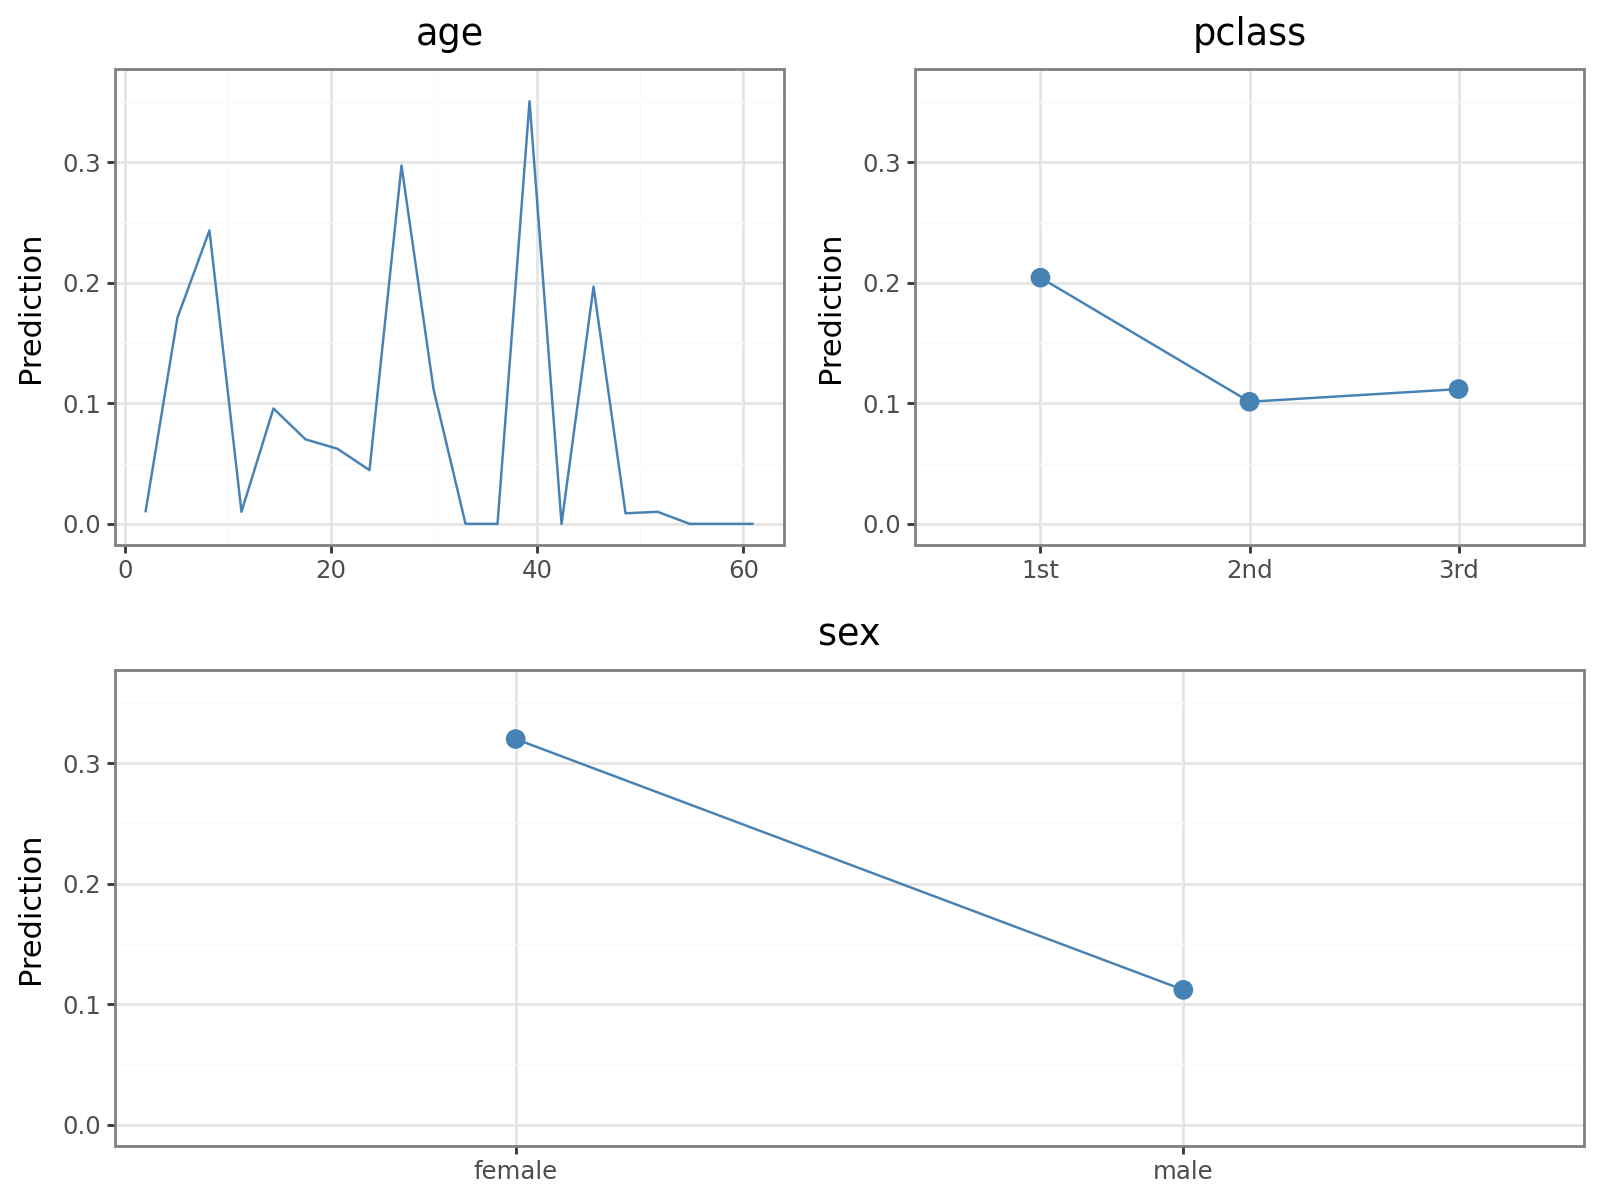

In [8]:
clf_rf.plot("pred")

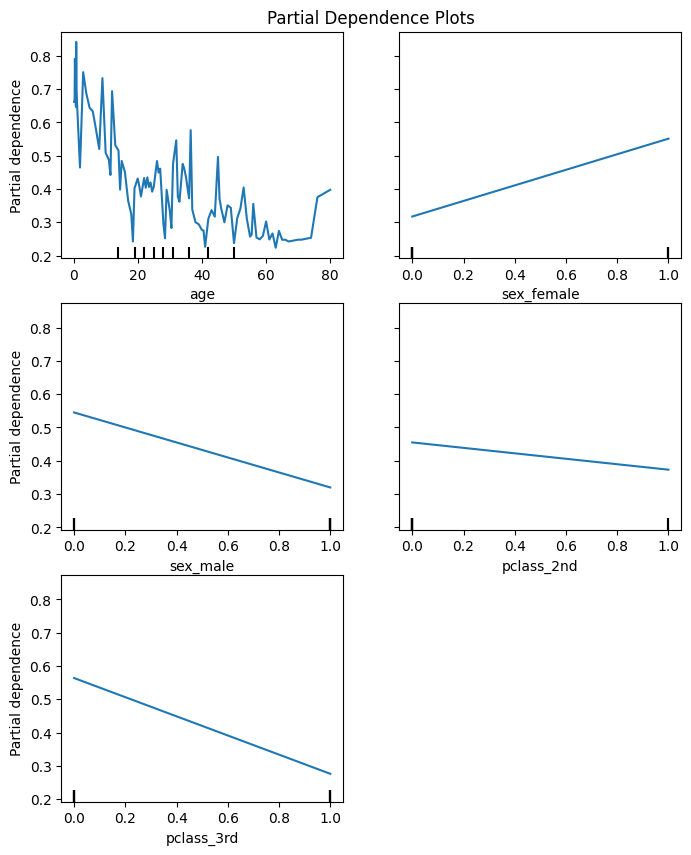

In [9]:
clf_rf.plot("pdp")

In [10]:
clf_rf.plot("vimp")

variable,importance
str,f64
"""sex""",0.271754
"""pclass""",0.180035
"""age""",0.168205


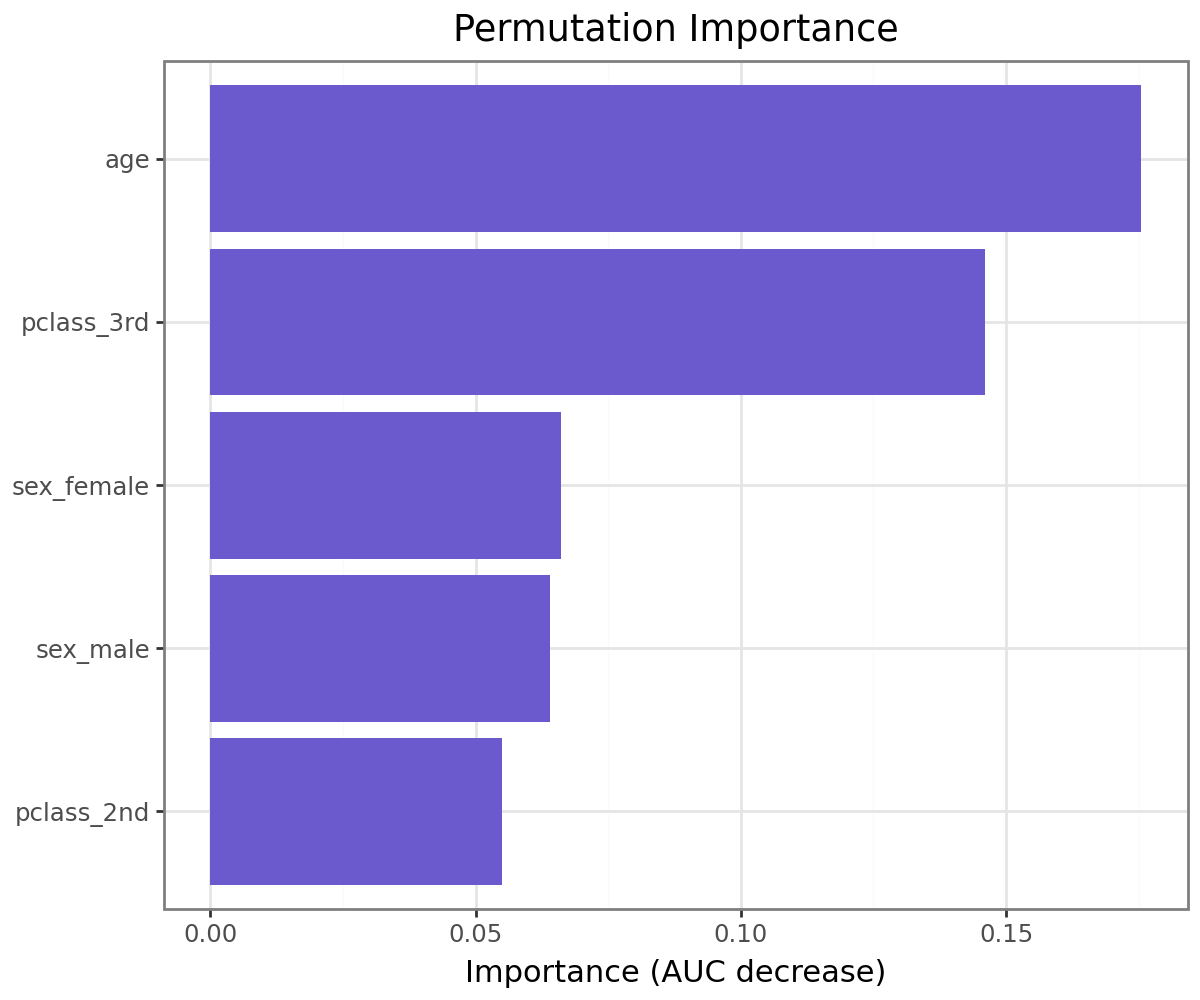

In [11]:
clf_rf.plot("vimp_sklearn")

In [12]:
clf_rf.predict()

pclass,sex,age,prediction
cat,cat,f64,f64
"""1st""","""female""",29.0,1.0
"""1st""","""male""",0.9167,0.885714
"""1st""","""female""",2.0,0.951705
"""1st""","""male""",30.0,0.287177
"""1st""","""female""",25.0,1.0
…,…,…,…
"""3rd""","""male""",45.5,0.531982
"""3rd""","""female""",14.5,0.612885
"""3rd""","""male""",26.5,0.208959


In addition to the numerical output provided in the _Summary_ tab we can also evaluate the link between `survival`, `class`, `sex`, and `age` visually (see _Plot_ tab). 


# Radiant for Python App: Random Forest - Classification

All the output shown above can be reproduced using the Radiant-for-Python web interface. An example of what the code required to start the web interface is shown below. See if you can reproduce the result.

> Note: The app will continue running until you press the `Stop` button in the app navigation bar or the stop button next to the notebook cell


In [13]:
# uncomment the line below if you want to use the radiant web interface
# rsm.radiant.model.rforest({"titanic": titanic}, {"titanic": titanic_description})

<p align="center">
<img src="figures/rf-classification-summary.png">
</p>

<p align="center">
<img src="figures/rf-classification-pred-plots.png">
</p>


## Tuning a Random Forest model

When building a Random Forest model, there are several hyperparameters that can be tuned to improve model performance. Two key parameters we'll focus on are:

- `max_features`: The number of features to consider for each split
- `n_estimators`: The number of trees in the forest

To find the optimal combination of these parameters, we'll:

1. Split our data into training (70%) and test (30%) sets
2. Use grid search with 5-fold cross validation to evaluate different parameter combinations
3. Compare model performance with default vs tuned parameters

First, let's create our train/test split:

In [14]:
titanic = titanic.with_columns(
    training=rsm.model.make_train(titanic, strat_var="survived", test_size=0.3, random_state=1234)
)

In [15]:
clf_rf = rsm.model.rforest(
    data={"titanic (train)": titanic.filter(pl.col("training") == 1)},
    rvar="survived",
    lev="Yes",
    evar=["pclass", "sex", "age"],
    max_features=2,
    n_estimators=100,
)
clf_rf.summary()

Random Forest
Data                 : titanic (train)
Response variable    : survived
Level                : Yes
Explanatory variables: pclass, sex, age
OOB                  : True
Model type           : classification
Nr. of features      : (3, 5)
Nr. of observations  : 730
max_features         : 2 (2)
n_estimators         : 100
min_samples_leaf     : 1
max_samples          : 1.0
random_state         : 1234
AUC                  : 0.808

Estimation data      :
shape: (5, 5)
┌────────┬────────────┬──────────┬────────────┬────────────┐
│ age    ┆ sex_female ┆ sex_male ┆ pclass_2nd ┆ pclass_3rd │
│ ---    ┆ ---        ┆ ---      ┆ ---        ┆ ---        │
│ f64    ┆ u8         ┆ u8       ┆ u8         ┆ u8         │
╞════════╪════════════╪══════════╪════════════╪════════════╡
│ 0.9167 ┆ 0          ┆ 1        ┆ 0          ┆ 0          │
│ 2.0    ┆ 1          ┆ 0        ┆ 0          ┆ 0          │
│ 25.0   ┆ 1          ┆ 0        ┆ 0          ┆ 0          │
│ 53.0   ┆ 1          ┆ 0        ┆

In [16]:
titanic = titanic.with_columns(pref_rd=clf_rf.predict(titanic).get_column("prediction"))
titanic

pclass,survived,sex,age,sibsp,parch,fare,name,cabin,embarked,training,pref_rd
cat,cat,cat,f64,i32,i32,f64,str,str,cat,i64,f64
"""1st""","""Yes""","""female""",29.0,0,0,211.337494,"""Allen, Miss. Elisabeth Walton""","""B5""","""Southampton""",0,0.989643
"""1st""","""Yes""","""male""",0.9167,1,2,151.550003,"""Allison, Master. Hudson Trevor""","""C22 C26""","""Southampton""",1,0.963333
"""1st""","""No""","""female""",2.0,1,2,151.550003,"""Allison, Miss. Helen Loraine""","""C22 C26""","""Southampton""",1,0.241833
"""1st""","""No""","""male""",30.0,1,2,151.550003,"""Allison, Mr. Hudson Joshua Cre…","""C22 C26""","""Southampton""",0,0.025
"""1st""","""No""","""female""",25.0,1,2,151.550003,"""Allison, Mrs. Hudson J C (Bess…","""C22 C26""","""Southampton""",1,0.39
…,…,…,…,…,…,…,…,…,…,…,…
"""3rd""","""No""","""male""",45.5,0,0,7.2249999,"""Youseff, Mr. Gerious""","""""","""Cherbourg""",1,0.140952
"""3rd""","""No""","""female""",14.5,1,0,14.4542,"""Zabour, Miss. Hileni""","""""","""Cherbourg""",0,0.562857
"""3rd""","""No""","""male""",26.5,0,0,7.2249999,"""Zakarian, Mr. Mapriededer""","""""","""Cherbourg""",1,0.076258


In [17]:
titanic

pclass,survived,sex,age,sibsp,parch,fare,name,cabin,embarked,training,pref_rd
cat,cat,cat,f64,i32,i32,f64,str,str,cat,i64,f64
"""1st""","""Yes""","""female""",29.0,0,0,211.337494,"""Allen, Miss. Elisabeth Walton""","""B5""","""Southampton""",0,0.989643
"""1st""","""Yes""","""male""",0.9167,1,2,151.550003,"""Allison, Master. Hudson Trevor""","""C22 C26""","""Southampton""",1,0.963333
"""1st""","""No""","""female""",2.0,1,2,151.550003,"""Allison, Miss. Helen Loraine""","""C22 C26""","""Southampton""",1,0.241833
"""1st""","""No""","""male""",30.0,1,2,151.550003,"""Allison, Mr. Hudson Joshua Cre…","""C22 C26""","""Southampton""",0,0.025
"""1st""","""No""","""female""",25.0,1,2,151.550003,"""Allison, Mrs. Hudson J C (Bess…","""C22 C26""","""Southampton""",1,0.39
…,…,…,…,…,…,…,…,…,…,…,…
"""3rd""","""No""","""male""",45.5,0,0,7.2249999,"""Youseff, Mr. Gerious""","""""","""Cherbourg""",1,0.140952
"""3rd""","""No""","""female""",14.5,1,0,14.4542,"""Zabour, Miss. Hileni""","""""","""Cherbourg""",0,0.562857
"""3rd""","""No""","""male""",26.5,0,0,7.2249999,"""Zakarian, Mr. Mapriededer""","""""","""Cherbourg""",1,0.076258


In [18]:
titanic = titanic.with_columns(pred_rf=clf_rf.predict(titanic).get_column("prediction"))

There is something interesting happening in the graph below. Compare this graph with the next one which seems to have no overfitting. The issue is connected to OOB. Use Advanced Voice Mode in ChatGPT to have a discussion about OOB and overfitting in Random Forest models.

In [19]:
dct = {
    "train": titanic.filter(pl.col("training") == 1),
    "test": titanic.filter(pl.col("training") == 0),
}
fig = rsm.model.gains_plot(dct, rvar="survived", lev="Yes", pred="pred_rf")

In [20]:
# For OOB predictions on training data only, use filter and update
# titanic.loc[titanic.training == 1, "pred_rf"] = clf_rf.predict()["prediction"]
# This pandas syntax doesn't work in polars - the prediction above already covers all data

In [21]:
dct = {
    "train": titanic.filter(pl.col("training") == 1),
    "test": titanic.filter(pl.col("training") == 0),
}
fig = rsm.model.gains_plot(dct, rvar="survived", lev="Yes", pred="pred_rf")

AttributeError: 'DataFrame' object has no attribute 'training'

The initial model used default parameters. Let's evaluate different combinations of parameters using grid search cross validation. We'll try:

- max_features: 1 to 5 features
- n_estimators: 100 to 500 trees (in steps of 100)

We'll use the AUC (Area Under the ROC Curve) metric to evaluate performance:

In [ ]:
param_grid = {"max_features": list(range(1, 6)), "n_estimators": np.arange(100, 600, 100)}
scoring = {"AUC": "roc_auc"}
param_grid

In [ ]:
# store cross validation object in a file to avoid re-computing it every time
cv_file = "cv-objects/clf-rf-cross-validation-object.pkl"
if os.path.exists(cv_file):
    cv = rsm.load_state(cv_file)["cv"]
else:
    stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
    cv = GridSearchCV(
        clf_rf.fitted,
        param_grid,
        scoring=scoring,
        cv=stratified_k_fold,
        n_jobs=4,
        refit=list(scoring.keys())[0],
        verbose=5,
    ).fit(clf_rf.data_onehot, clf_rf.data.survived)
    if not os.path.exists("cv-objects"):
        os.mkdir("cv-objects")
    rsm.save_state({"cv": cv}, cv_file)

In [ ]:
# same functionality as the cell above but with less typing
cv = rsm.model.cross_validation(clf_rf, "clf-rf", param_grid, scoring)

In [ ]:
cv.best_params_

In [ ]:
cv.best_score_

In [ ]:
pl.DataFrame(cv.cv_results_).sort("rank_test_AUC").head()

After finding the optimal parameters, we can build a new model with these tuned parameters and compare its performance to our original model. Looking at the gains charts for both the training and test sets helps us evaluate overfitting while maintaining good predictive performance.

The cross validation results show that slightly different parameter values perform best with this particular dataset compared to the defaults. This demonstrates the value of parameter tuning, though the magnitude of improvement will vary by application.

In [ ]:
clf_rfcv = rsm.model.rforest(
    data={"titanic (train)": titanic.filter(pl.col("training") == 1)},
    rvar="survived",
    lev="Yes",
    evar=["pclass", "sex", "age"],
    random_state=1234,
    **cv.best_params_,
)
clf_rfcv.summary()

In [ ]:
titanic = titanic.with_columns(pred_rfcv=clf_rfcv.predict(titanic).get_column("prediction"))
titanic

In [ ]:
dct = {
    "train": titanic.filter(pl.col("training") == 1),
    "test": titanic.filter(pl.col("training") == 0),
}
fig = rsm.model.gains_plot(dct, rvar="survived", lev="Yes", pred="pred_rfcv")

In [ ]:
# For OOB predictions on training data only, use filter and update
# titanic.loc[titanic.training == 1, "pred_rfcv"] = clf_rfcv.predict()["prediction"]
# This pandas syntax doesn't work in polars - the prediction above already covers all data

In [ ]:
dct = {
    "train": titanic.filter(pl.col("training") == 1),
    "test": titanic.filter(pl.col("training") == 0),
}
fig = rsm.model.gains_plot(dct, rvar="survived", lev="Yes", pred="pred_rfcv")

In [ ]:
fig = rsm.model.gains_plot(
    {"train": titanic.filter(pl.col("training") == 1)},
    rvar="survived",
    lev="Yes",
    pred=["pred_rf", "pred_rfcv"],
)

In [ ]:
fig = rsm.model.gains_plot(
    {"test": titanic.filter(pl.col("training") == 0)},
    rvar="survived",
    lev="Yes",
    pred=["pred_rf", "pred_rfcv"],
)

In [ ]:
# test script for issue https://github.com/scikit-learn/scikit-learn/issues/30675
# restrict sklearn version to 1.5.2 or older to avoid this bug
# import numpy as np
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.inspection import PartialDependenceDisplay

# np.random.seed(42)
# n_samples = 1000
# age = np.random.normal(35, 10, n_samples)
# smoker = np.random.choice([0, 1], n_samples, p=[0.7, 0.3])
# prob_disease = 1 / (1 + np.exp(-(age - 35) / 10 - 2 * smoker))
# heart_disease = (np.random.random(n_samples) < prob_disease).astype(int)
# df = pd.DataFrame({"age": age, "smoker": smoker, "heart_disease": heart_disease})
# X = df[["age", "smoker"]]
# y = df["heart_disease"]

# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_model.fit(X, y)

# pdp_age = PartialDependenceDisplay.from_estimator(rf_model, X, features=[0, 1])